# Singular Spectrum Analysis

# Setup

In [1]:
# Usual Suspects
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import pandas as pd

# Configs
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 14
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.linewidth'] = 2

#default color cycle
from cycler import cycler
cols = plt.get_cmap('tab10').colors
plt.rcParams['axes.prop_cycle'] = cycler(color=cols)

# plot helper (clean)
def plot_2d(m, title=''):
    plt.imshow(m)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    
np.random.seed(1337)

# Generate the Time Series

We will generate an arbitrary time series $F = \{f_0, f_1, \ldots, f_{N-1}\}$ consisting of 
- trend
- periodicities
- noise

Here we go:

$$f_t = 0.001 \times (t-100)^2 + 2\sin(\frac{2\pi t}{p_1}) + 0.75\sin(\frac{2\pi t}{p_2}) + \text{Rand}\{-1,1\}$$

with $t \in \{0, 1, \ldots, N-1\} \subset \mathbb{N}$ as discrete time moment and
$\text{Rand}\{-1,1\}$ a random number uniformly distributed between $-1$ and $1$, introducing noise.

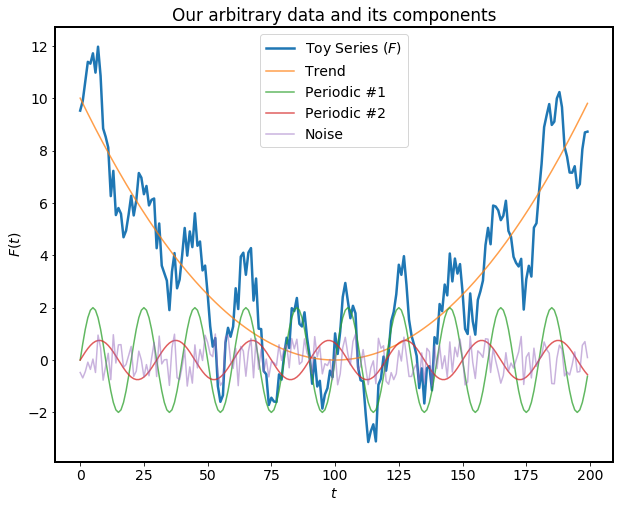

In [2]:
N = 200
t = np.arange(0, N)
trend = 0.001 * (t - 100)**2
p1, p2 = 20, 30
periodic1 = 2 * np.sin(2*pi*t/p1)
periodic2 = 0.75 * np.sin(2*pi*t/p2)

noise = 2* (np.random.rand(N) - 0.5)
F = trend + periodic1 + periodic2 + noise

plt.plot(t, F, lw=2.5)
plt.plot(t, trend, alpha=0.75)
plt.plot(t, periodic1, alpha=0.75)
plt.plot(t, periodic2, alpha=0.75)
plt.plot(t, noise, alpha=0.5)
plt.legend([
    "Toy Series ($F$)",
    "Trend",
    "Periodic #1",
    "Periodic #2",
    "Noise"
])
plt.xlabel("$t$")
plt.ylabel("$F(t)$")
plt.title("Our arbitrary data and its components");

# SSA

## 1. The trajectory matrix $X$

We first decompose $F$ into a sequence of multi-dimensional lagged vectors. We define $L$ to be the **window length**, $2 \le L \le N/2 \in \mathbb{N}$.

Now we define a sequence of sequences of 'windows':

\begin{align*}
X_0 &= (f_0, f_1, \ldots ,f_{L-1})^\text{T} \\
X_1 & = (f_i, f_{i+1}, \ldots ,f_{i+L-1})^\text{T} \\
& \quad \quad \quad \vdots \\
X_{N-L} &= (f_{N-L}, \ f_{N-L+1},\ \ldots, f_{N-1})^\text{T}
\end{align*}

And with these column vectors, we form the $L$-*trajectory matrix*, $\mathbf{X}$ of the time series (short: trajectory matrix):

$$\mathbf{X} = \begin{pmatrix}
f_0 & f_1 & f_2 & f_3 &\ldots & f_{N-L} \\ 
f_1 & f_2 & f_3 & f_4 &\ldots & f_{N-L+1} \\
f_2 & f_3 & f_4 & f_5 &\ldots & f_{N-L+2} \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
f_{L-1} & f_{L} & f_{L+1} & f_{L+2} & \ldots & f_{N-1} \\ 
\end{pmatrix}$$

Pay attention to the **anti-diagonal** character! This type of matrix is called ***Hankel*** matrix. We furthermore define 
$$ K := N - L +1$$
and refer to the 
- columns of $\mathbf{X}$ as the **$L$-lagged vectors**
and 
- the rows as the **$K$-lagged vectors.**

In [3]:
L = 70
K = N - L + 1
X = np.column_stack([F[i:i+L] for i in range(0,K)])

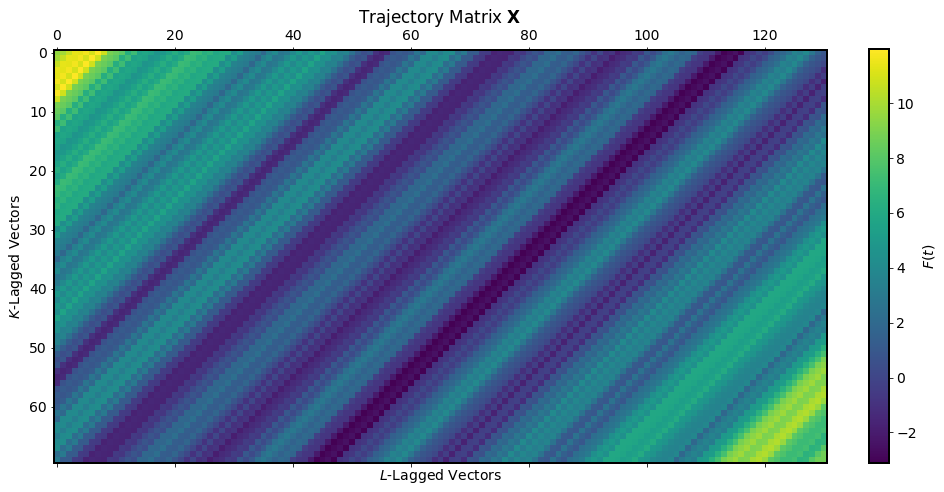

In [4]:
ax = plt.matshow(X)
plt.xlabel("$L$-Lagged Vectors")
plt.ylabel("$K$-Lagged Vectors")
plt.colorbar(ax.colorbar, fraction=0.0248)
ax.colorbar.set_label("$F(t)$")
plt.title("Trajectory Matrix $\mathbf{X}$");

## 2. Decomposing the trajectory matrix $\mathbf{X}$

A matrix is a linear operation, which can generally be rewritten (respectively decomposed) as a sequence of multiple linear operation. Thus, there are multiple ways to decompose a matrix into a product (sometimes sum) of other matrices, with specific properties each.
Most important decomposition options are:

- eigenvalue decomposition
- singular value decomposition (SVD)
- LU decomposition
- polar decomposition

We will chose SVD for reasons to be explained forthcoming. SVD decomposes $\mathbf{X}$ like following:

$$\mathbf{X} = \mathbf{U\Sigma V}^{\text{T}}$$ 
where:
* $\mathbf{U}$ is an $L \times L$ unitary matrix containing the orthonormal set of ***left singular vectors*** of $\mathbf{X}$ as columns;
* $\mathbf{\Sigma}$ is an $L \times K$ rectangular diagonal matrix containing $L$ ***singular values*** of $\mathbf{X}$, ordered from largest to smallest; and
* $\mathbf{V}$ is a $K \times K$ unitary matrix containing the orthonormal set of ***right singular vectors*** of $\mathbf{X}$ as columns.

The SVD of the trajectory matrix can be rewritten as 
\begin{align*}
    \mathbf{X} & = \sum_{i=0}^{d-1}\sigma_i U_i V_i^{\text{T}} \\
               & \equiv \sum_{i=0}^{d-1}\mathbf{X}_i
\end{align*}
where $\sigma_i$ is the $i$th singular value, $U_i$ and $V_i$ are vectors representing the $i$th columns of $\mathbf{U}$ and $\mathbf{V}$, respectively, $d \le L$ is the *rank* of the trajectory matrix (which I shall elaborate on shortly), and $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$ is the $i$th ***elementary matrix*** of $\mathbf{X}$. The collection $\{U_i, \sigma_i, V_i\}$ will be denoted the $i$th ***eigentriple*** of the SVD.

## 2.1 The $\mathbf{U}$ Matrix

Since $\mathbf{U}$ is an $L \times L$ matrix whose columns are orthonormal, that is
$$
U_i \cdot U_j = \left\{
\begin{array}{lr}
1 \ & i = j \\
0 \ & i \ne j
\end{array}
\right.
$$
Hence $\mathbf{UU}^\text{T} = \mathbf{U}^\text{T}\mathbf{U} = \mathbf{1}$ and therefor $\mathbf{U}$ unitary.

Which role plays $\mathbf{U}$ in the (SVD-)expansion for our trajectory matrix $\mathbf{X}$?

So set
$$Z_i := \sigma_i V_i$$
then
$$\mathbf{X} = \sum_{i=0}^{d-1} U_i Z_i^\text{T}$$
and each $L$-lagged column vector, $X_j$, is then given by
$$X_j = \sum_{i=0}^{d-1}z_{ji}U_i$$
with $z_{ji}$ is the $j$th component of $Z_i$. The expression $X_j$ suggests that $\mathcal{U} = \{U_0, \ldots, U_{d-1} \}$ is a basis set spanning the *column space* of the trajectory matrix, and $z_{ji}$ is the $i$th coefficient of the lagged vector $X_j$ represented in the basis $\mathcal{U}$.
Or, in other words:
**The columns of $\mathbf{U}$ form an (orthonormal) basis set for the columns of the trajectory matrix.**

## 2.2 The $\mathbf{V}$ Matrix

Let's take a shortcut:
Analog to the $\mathbf{U}$ matrix we come to the conclusion, that
**the columns of $\mathbf{V}$ form an (orthonormal) basis set for the rows of the trajectory matrix.**

## 2.3 The $\mathbf{\Sigma}$ matrix

The $\mathbf\Sigma$ matrix is a $L \times K$ matrix, that has only Null values except the diagonal, which contains the **singular values** of $\mathbf{X}$, ordered descending:
$$\sigma_0 \ge \sigma_1 \ge \ldots \ge \sigma_{L-1} \ge 0$$

We need one further tool, a norm on matrices.
The *Frobenius norm* of $\mathbf{X}$, $\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}$, is given by
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}} = \sqrt{\sum_{j=0}^{L-1}\sum_{k=0}^{K-1} \lvert x_{jk}\rvert^2}$$
where $x_{jk}$ denotes the element in the $j$th row and $k$th column of $\mathbf{X}$.

Let's turn our attention to the elementary matrices $\mathbf{X}_i = \sigma_i U_i V_i^{\text{T}}$. Now, for an outer product such as $U_i V_i^{\text{T}}$, we have  $\lvert \lvert U_i V_i^{\text{T}} \rvert \rvert_{\text{F}} = \lvert \lvert U_i \rvert \rvert_{\text{F}} \lvert \lvert V_i \rvert \rvert_{\text{F}}$, which is simply equal to 1 due to $U_i$ and $V_i$ being orthonormal and thus normalised. From this result, it is then clear that $\lvert\lvert \mathbf{X}_i \rvert\rvert_{\text{F}} = \sigma_i$. It also turns out that 
$$\lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2 = \sum_{i=0}^{d-1} \sigma_i^2$$
i.e. **the squared Frobenius norm of the trajectory matrix is equal to the sum of the squared singular values. This suggests that we can take the ratio $\sigma_i^2 / \lvert\lvert \mathbf{X} \rvert\rvert_{\text{F}}^2$ as a measure of the contribution that the elementary matrix $\mathbf{X}_i$ makes in the expansion of the trajectory matrix.**

Further, if we right-multiply the original SVD of $\mathbf{X}$ by $\mathbf{X}^{\text{T}}$:
\begin{align*}
    \mathbf{XX}^{\text{T}} & = \mathbf{U\Sigma V}^{\text{T}}\mathbf{X}^{\text{T}} \\
               & = \mathbf{U\Sigma V}^{\text{T}} \mathbf{V \Sigma}^{\text{T}}\mathbf{U}^{\text{T}} \\
               & = \mathbf{U\Sigma} \mathbf{\Sigma}^{\text{T}}\mathbf{U}^{\text{T}}
\end{align*}
Letting the square diagonal matrix $\mathbf{\Sigma}^2 = \mathbf{\Sigma \Sigma}^{\text{T}}$, and multiplying on the right by $\mathbf{U}$, gives
$$(\mathbf{XX}^{\text{T}})\mathbf{U} = \mathbf{U}\mathbf{\Sigma}^2$$
which—given that $\mathbf{\Sigma}^2$ is a diagonal matrix with elements $\sigma_i^2$—demonstrates that the columns of $\mathbf{U}$ are eigenvectors of the matrix $\mathbf{XX}^{\text{T}}$, with eigenvalues $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$. Following a similar argument, multiplying $\mathbf{X}$ on the left by $\mathbf{X}^{\text{T}}$ shows that the columns of $\mathbf{V}$ are eigenvectors of the matrix $\mathbf{X}^{\text{T}}\mathbf{X}$, also with eigenvalues $\{\sigma_0^2, \ldots , \sigma_{L-1}^2\}$.

## 2.4 The rank of trajectory matrix $\mathbf{X}$

The columns of the trajectory matrix are a sequence of $L$-lagged vectors, which span the *trajectory space* of the time series. This space will be at most $L$-dimensional; however, if the columns in $\mathbf{X}$ are linearly dependent, then the trajectory space will have $d < L$ dimensions. This manifests as one or more zero singular values in $\mathbf{\Sigma}$. **The rank of $\mathbf{X}$ is the maximum value of $i$ such that $\sigma_i > 0$. Put another way, $d = \text{rank}\{\mathbf{X}\}$ can be regarded as the instrinsic dimensionality of the time series' trajectory space.**

(Note: for noisy real-world time series data, the trajectory space is likely to have $d = L$ dimensions.)

It is important to note that each elementary matrix $\mathbf{X}_i$ has a rank of 1, and that the matrix 
$$\mathbf{X}^{(r)} = \sum_{i=0}^{r} \mathbf{X}_i$$
for $r < d$, is the best rank-$r$ approximation to the trajectory matrix $\mathbf{X}$, such that $\lvert\lvert \mathbf{X} - \mathbf{X}^{(r)}\rvert\rvert_F$ is minimised. **That is, we can sum the first $r$ elementary matrices to obtain an optimal, lower-dimensional approximation of $\mathbf{X}$**.

Further Resources:
- [how to implement SVD on your own](http://www.aip.de/groups/soe/local/numres/bookfpdf/f2-6.pdf)

In [5]:
d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.

U, Sigma, V = np.linalg.svd(X)
V = V.T #the SVD routine returns V^T, not V! Tranpose it back here for consistency with the mathematical notation in this notebook.

# Calculate the elementary matrices of X, storing them in a multidimensional NumPy array.
# This requires calculating sigma_i * U_i * (V_i)^T for each i, or sigma_i * outer_product(U_i, V_i). 
# Note that Sigma is a 1D array of singular values, instead of the full L x K diagonal matrix.
X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )

# Quick sanity check: the sum of all elementary matrices in X_elm should be equal to X, to within a 
# *very small* tolerance:
if not np.allclose(X, X_elem.sum(axis=0), atol=1e-10):
    print("WARNING: The sum of X's elementary matrices is not equal to X!")

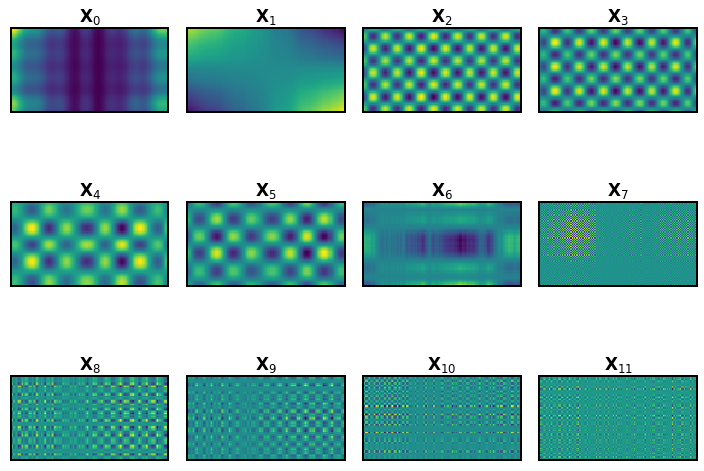

In [6]:
n = min(12, d) # In case d is less than 12 for the toy series. Say, if we were to exclude the noise component...
for i in range(n):
    plt.subplot(3,4,i+1)
    title = "$\mathbf{X}_{" + str(i) + "}$"
    plot_2d(X_elem[i], title)
plt.tight_layout()

In [7]:
X

array([[ 9.52404935,  9.8923357 , 10.64087603, ...,  2.86825919,
         1.54454126,  0.92337546],
       [ 9.8923357 , 10.64087603, 11.3865067 , ...,  1.54454126,
         0.92337546,  0.57743188],
       [10.64087603, 11.3865067 , 11.31747273, ...,  0.92337546,
         0.57743188,  0.15480297],
       ...,
       [ 4.27517021,  2.26969678,  3.11348301, ...,  6.56563974,
         6.71884244,  8.04945333],
       [ 2.26969678,  3.11348301,  1.19823486, ...,  6.71884244,
         8.04945333,  8.69182342],
       [ 3.11348301,  1.19823486,  1.18092147, ...,  8.04945333,
         8.69182342,  8.72047979]])

Let's plot the relative contributions, $\dfrac{\sigma_i^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, and the cumulative contributions, $\dfrac{\sum_{j=0}^i \sigma_j^2}{\sum_{k=0}^{d-1} \sigma_k^2}$, of the first 12 elementary matrices to the trajectory matrix of the toy time series:

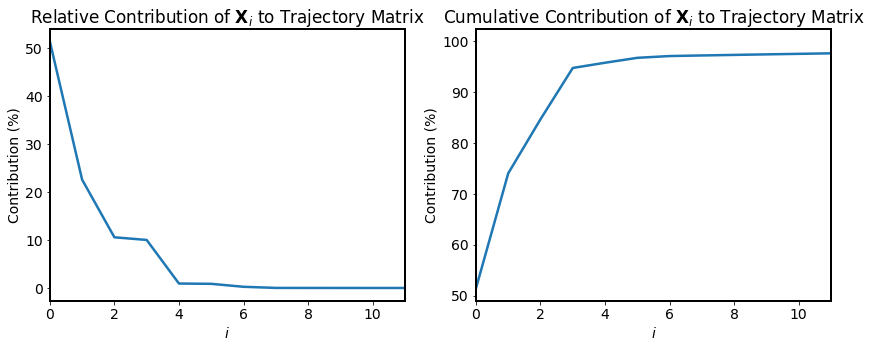

In [8]:
sigma_sumsq = (Sigma**2).sum()
fig, ax = plt.subplots(1, 2, figsize=(14,5))
ax[0].plot(Sigma**2 / sigma_sumsq * 100, lw=2.5)
ax[0].set_xlim(0,11)
ax[0].set_title("Relative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[0].set_xlabel("$i$")
ax[0].set_ylabel("Contribution (%)")
ax[1].plot((Sigma**2).cumsum() / sigma_sumsq * 100, lw=2.5)
ax[1].set_xlim(0,11)
ax[1].set_title("Cumulative Contribution of $\mathbf{X}_i$ to Trajectory Matrix")
ax[1].set_xlabel("$i$")
ax[1].set_ylabel("Contribution (%)");

The elementary matrices $\mathbf{X}_0$ and $\mathbf{X}_1$ contribute 52% and 22%, respectively, to the expansion of  $\mathbf{X}$. Together, the first seven elementary matrices contribute 97%. Elementary matrices that make equal contributions to the expansion (that is, $\sigma_i \approx \sigma_{i+1}$) are likely to be grouped together when reconstructing the time series, and appear as "breaks" in the plot of relative contributions. For example, the "breaks" in the plot above suggest that $\mathbf{X}_2$ and $\mathbf{X}_3$, and $\mathbf{X}_4$ and $\mathbf{X}_5$, should be grouped together. 

It is important to note that the elementary matrices represent an **optimal** (although possibly non-unique) separation of components in trajectory space: by definition, the rows and columns of one elementary matrix are orthogonal to the rows and columns of the other elementary matrices. However, this separation may not coincide with what we would consider a useful, interpretable 'component' of the time series. In fact, there are restrictions on the types of time series components that are exactly separable under this formalism.

# 3. Reconstructing the time series

So far, we have mapped a time series $F$ to a series of $L$-lagged vectors, forming the *trajectory matrix* of $F$. We then decomposed this matrix with a singular-value decomposition, and constructed a set of *elementary matrices* which comprise the trajectory matrix. We then gave a bit of a hand-waving explanation to classify these elementary matrices as *trend*, *periodicity* and *noise*. 

In a perfect world, all the components of a time series $F = \sum_j F^{(j)}$ would be separable, and we would have grouped the the resulting elementary matrices $\mathbf{X}_i$ appropriately, such that
\begin{align*}
\mathbf{X} &  = \sum_{k \in \mathcal{S}}\mathbf{X}_k + \sum_{l \in \mathcal{T}}\mathbf{X}_l + \ldots \\
             &  = \sum_j \mathbf{X}^{(j)}
\end{align*}
where $\mathcal{S}$ and $\mathcal{T}$ are disjoint (i.e. non-overlapping) sets of indices, and $\mathbf{X}^{(j)}$ is the trajectory matrix of the time series component $F^{(j)}$. In this case, each $\mathbf{X}^{(j)}$ would have a Hankel structure like the original trajectory matrix, and construction of each $F^{(j)}$ would be simple. However, in this imperfect real world, no component trajectory matrices will have equal values on their anti-diagonals. Therefore, we seek a process to transform an elementary matrix to a Hankel matrix, and then into a time series.

To extract a time series from the elementary matrices, we'll employ ***diagonal averaging***, which defines the values of the reconstructed time series $\tilde{F}^{(j)}$ as averages of the corresponding anti-diagonals of the matrices $\mathbf{X}^{(j)}$. Formally, this is represented by introducing the *Hankelisation* operator, $\hat{\mathcal{H}}$, that acts on the $L \times K$ matrix $\mathbf{X}^{(j)}$ to give a Hankel matrix $\mathbf{\tilde{X}}^{(j)}$; that is, 
$$\mathbf{\tilde{X}}^{(j)} = \hat{\mathcal{H}}\mathbf{X}^{(j)}$$ 
The element $\tilde{x}_{m,n}$ in $\mathbf{\tilde{X}}^{(j)}$, for $s = m+n$, is given by
$$
\tilde{x}_{m,n} = \left\{
  \begin{array}{lr}
    \frac{1}{s+1}\sum_{l=0}^{s} x_{l, s-l} & \ 0 \le s \le L-1 \\
    \frac{1}{L-1}\sum_{l=0}^{L-1} x_{l, s-l} & \ L \le s \le K-1 \\
    \frac{1}{K+L-s-1}\sum_{l=s-K+1}^{L} x_{l, s-l} & \ K \le s \le K+L-2 \\
  \end{array}
\right.
$$

At first glance, the above looks like an impenetrable soup of matrix indices. However, all it is doing is calculating the given $\tilde{x}_{m,n}$ by averaging the rest of the elements of the anti-diagonal wherein $\tilde{x}_{m,n}$ belongs. The number of anti-diagonal elements to sum depends on the location of $m$ and $n$ in the matrix, and hence the index soup. **In practice, we don't need the full Hankel matrix $\mathbf{\tilde{X}}^{(j)}$, and can cut straight to the construction of the time series $\tilde{F}^{(j)}$. However, I've included the definition of $\hat{\mathcal{H}}\mathbf{X}^{(j)}$ above to complete the mathematical exposition of SSA.**

It is important to note that $\hat{\mathcal{H}}$ is a linear operator, i.e.  $\hat{\mathcal{H}}(\mathbf{A} + \mathbf{B}) = \hat{\mathcal{H}}\mathbf{A} + \hat{\mathcal{H}}\mathbf{B}$. Then, for a trajectory matrix $\mathbf{X}$, 
\begin{align*}
\hat{\mathcal{H}}\mathbf{X} & = \hat{\mathcal{H}} \left( \sum_{i=0}^{d-1} \mathbf{X}_i \right) \\
                            &  = \sum_{i=0}^{d-1} \hat{\mathcal{H}} \mathbf{X}_i \\
                            &  \equiv \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}
\end{align*} 
As $\mathbf{X}$ is already a Hankel matrix, then by definition $\hat{\mathcal{H}}\mathbf{X} = \mathbf{X}$. Therefore, the trajectory matrix can be expressed in terms of its Hankelised elementary matrices:
$$\mathbf{X} = \sum_{i=0}^{d-1} \tilde{\mathbf{X}_i}$$
As a time series is uniquely determined from a Hankel matrix, the expression above also defines the time series $F$ as a sum of its components $\tilde{F}_i$. It is up to us to group these components together, and classify them as trend, periodicity or noise, and then we're free to decide how we use them. 

For fun, I've implemented a Hankelisation procedure below. However, don't get too attached to it, as it's going to be thrown away and replaced with something much more efficient and Pythonic.

In [9]:
def Hankelise(X):
    """
    Hankelises the matrix X, returning H(X).
    """
    L, K = X.shape
    transpose = False
    if L > K:
        # The Hankelisation below only works for matrices where L < K.
        # To Hankelise a L > K matrix, first swap L and K and tranpose X.
        # Set flag for HX to be transposed before returning. 
        X = X.T
        L, K = K, L
        transpose = True

    HX = np.zeros((L,K))
    
    # NOT pythonic...
    for m in range(L):
        for n in range(K):
            s = m+n
            if 0 <= s <= L-1:
                for l in range(0,s+1):
                    HX[m,n] += 1/(s+1)*X[l, s-l]    
            elif L <= s <= K-1:
                for l in range(0,L-1):
                    HX[m,n] += 1/(L-1)*X[l, s-l]
            elif K <= s <= K+L-2:
                for l in range(s-K+1,L):
                    HX[m,n] += 1/(K+L-s-1)*X[l, s-l]
    if transpose:
        return HX.T
    else:
        return HX

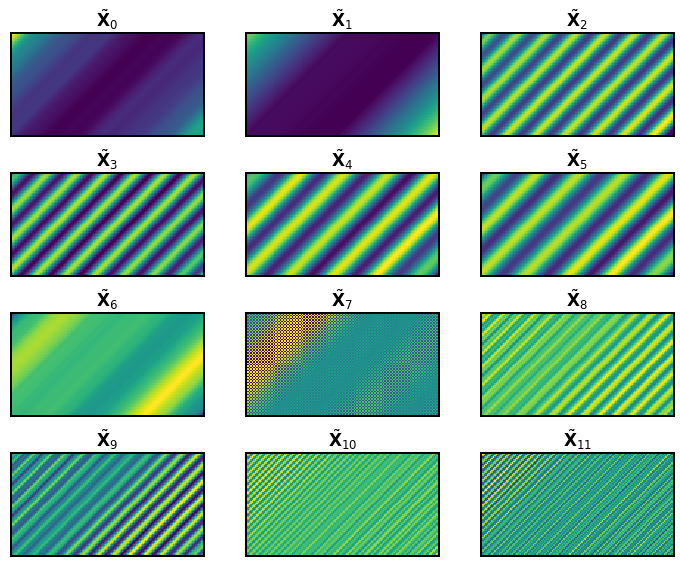

In [10]:
n = min(d, 12)
for j in range(0,n):
    plt.subplot(4,3,j+1)
    title = r"$\tilde{\mathbf{X}}_{" + str(j) + "}$"
    plot_2d(Hankelise(X_elem[j]), title)
plt.tight_layout() 

Inspection of the Hankelised elementary matrices of the toy time series confirms our suspicians about the elementary matrices: $\tilde{\mathbf{X}}_0$ and $\tilde{\mathbf{X}}_1$ vary slowly over the whole time series, and can be grouped together as the trend component. $\tilde{\mathbf{X}}_2$ and $\tilde{\mathbf{X}}_3$ are both periodic, with the same frequency, and can be grouped as the first periodic component. $\tilde{\mathbf{X}}_4$ and $\tilde{\mathbf{X}}_5$ are also periodic, with a different frequency to $\tilde{\mathbf{X}}_2$ and $\tilde{\mathbf{X}}_3$, and will be grouped as the second periodic component. $\tilde{\mathbf{X}}_6$, lacking obvious periodicity, will be grouped with the trend components. We'll lump together all components from $\tilde{\mathbf{X}}_7$ and beyond as noise. To summarise:
\begin{align*}
\tilde{\mathbf{X}}^{\text{(trend)}} & = \tilde{\mathbf{X}}_0 + \tilde{\mathbf{X}}_1 + \tilde{\mathbf{X}}_6 
    & \implies &  \tilde{F}^{\text{(trend)}} = \tilde{F}_0 + \tilde{F}_1 + \tilde{F}_6 \\
\tilde{\mathbf{X}}^{\text{(periodic 1)}} & = \tilde{\mathbf{X}}_2 + \tilde{\mathbf{X}}_3 
    & \implies & \tilde{F}^{\text{(periodic 1)}} = \tilde{F}_2 + \tilde{F}_3  \\
\tilde{\mathbf{X}}^{\text{(periodic 2)}} & = \tilde{\mathbf{X}}_4 + \tilde{\mathbf{X}}_5 
    & \implies & \tilde{F}^{\text{(periodic 2)}} = \tilde{F}_4 + \tilde{F}_5\\
\tilde{\mathbf{X}}^{\text{(noise)}} & = \tilde{\mathbf{X}}_7 + \ldots + \tilde{\mathbf{X}}_{69}
    & \implies & \tilde{F}^{\text{(noise)}} = \tilde{F}_7 + \ldots + \tilde{F}_{69}
\end{align*}
While we have defined the time series component grouping in terms of Hankelised elementary matrices, we will no longer calculate the full Hankel matrix $\tilde{\mathbf{X}}_i$, and instead calculate $\tilde{F}_i$ directly from $\mathbf{X}_i$.

In [11]:
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

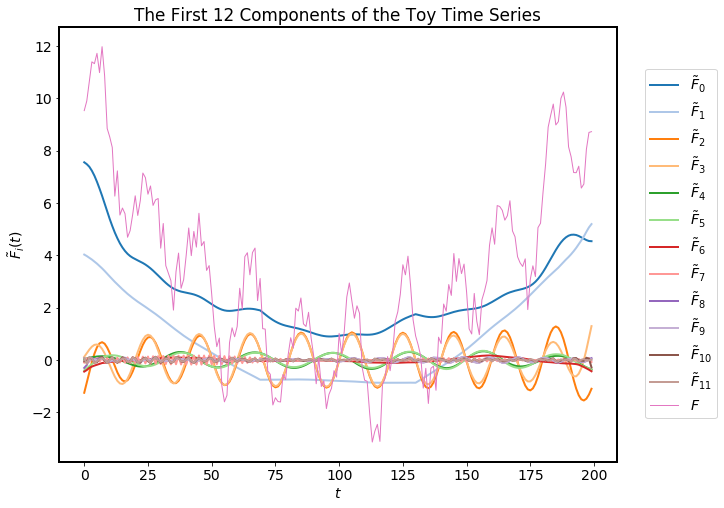

In [12]:
n = min(12,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, F, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("The First 12 Components of the Toy Time Series")
fig.legend(legend, loc=(1.05,0.1));

As mentioned earlier, the elementary components separated in the time series' trajectory space may not coincide with a single, interpretable component in the time series. For example, $\tilde{F}_0$ and $\tilde{F}_1$ both look vaguely like the trend—are they *really* separate components? Similarly, $\tilde{F}_2$ and $\tilde{F}_3$ are almost identical, except near the boundaries of the time series.

We'll introduce a way to quantify which $\tilde{F_i}$ should be grouped together, but for a moment, let's follow our instincts and apply our earlier grouping for $\tilde{F}^{\text{(trend)}}$,  $\tilde{F}^{\text{(periodic 1)}}$,  $\tilde{F}^{\text{(periodic 2)}}$ and  $\tilde{F}^{\text{(noise)}}$, and see how the SSA-separated components compare with the original components that compose the toy time series:

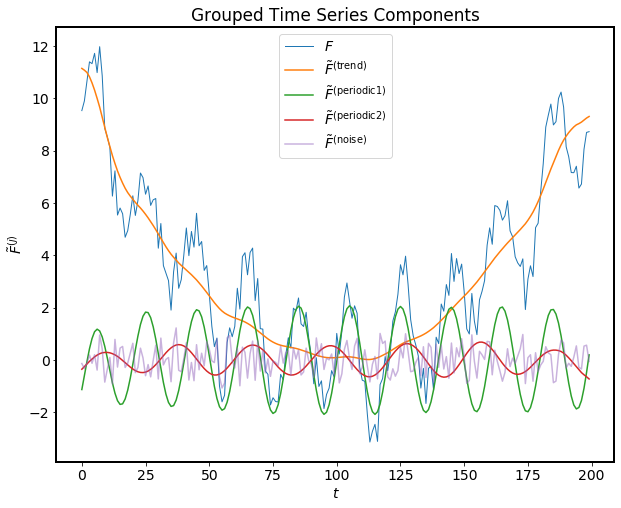

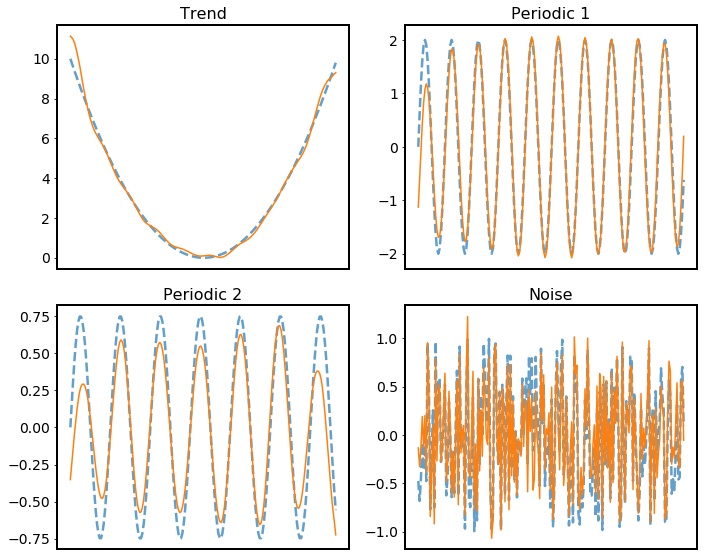

In [13]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem[[0,1,6]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem[[2,3]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem[7:].sum(axis=0))

# Plot the toy time series and its separated components on a single plot.
plt.plot(t,F, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
plt.plot(t, F_periodic2)
plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend", "periodic 1", "periodic 2", "noise"]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Time Series Components")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", trend, F_trend), 
              ("Periodic 1", periodic1, F_periodic1),
              ("Periodic 2", periodic2, F_periodic2),
              ("Noise", noise, F_noise)]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(2,2,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=16)
    ax.set_xticks([])
    n += 1

fig.tight_layout()

## 4. Time series component separation and grouping

So far, we have grouped the eigentriples/components of the toy time series together by visual inspection; that is, we decided which components belonged together by their appearance. This is fine for a short and simple time series, however, for longer and more complicated time series, we seek a method that quantifies whether a reconstructed component $\tilde{F}_i$ can be considered separate from another component $\tilde{F}_j$, so we don't need to make grouping decisions by visually inspecting each $\tilde{F}_i$.

For two reconstructed time series, $\tilde{F}_i$ and $\tilde{F}_j$, of length $N$, and a window length $L$, we define the *weighted inner product*, $(\tilde{F}_i, \tilde{F}_j)_w$ as:
$$(\tilde{F}_i, \tilde{F}_j)_w = \sum_{k=0}^{N-1} w_k \tilde{f}_{ik} \tilde{f}_{jk}$$
where $\tilde{f}_{ik}$ and $\tilde{f}_{jk}$ are the $k$th values of $\tilde{F}_i$ and $\tilde{F}_j$, respectively, and $w_k$ is given by
$$
w_{k} = \left\{
  \begin{array}{lr}
    k+1 & \ 0 \le k \le L-1 \\
    L & \ L \le k \le K-1 \\
    N - k & \ K \le k \le N-1 \\
  \end{array}
\right.
$$
remembering that $K = N - L + 1$. The weight $w_k$ simply reflects the number of times $\tilde{f}_{ik}$ and $\tilde{f}_{jk}$ appear in the Hankelised matrices $\mathbf{\tilde{X}}_i$ and $\mathbf{\tilde{X}}_j$, from which the time series $\tilde{F}_i$ and $\tilde{F}_j$ have been obtained.

Put simply, if $(\tilde{F}_i, \tilde{F}_j)_w = 0$, $\tilde{F}_i$ and $\tilde{F}_j$ are *w-orthogonal* and the time series components are separable. Of course, total w-orthogonality does not occur in real life, so instead we define a $d \times d$ ***weighted correlation*** matrix, $\mathbf{W}_{\text{corr}}$, which measures the deviation of the components $\tilde{F}_i$ and $\tilde{F}_j$ from w-orthogonality. The elements of $\mathbf{W}_{\text{corr}}$ are given by
$$W_{ij} = \frac{(\tilde{F}_i, \tilde{F}_j)_w}{\lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w}$$
where $\lVert \tilde{F}_k \rVert_w = \sqrt{(\tilde{F}_k, \tilde{F}_k)_w}$ for $k = i,j$. The interpretation of $W_{ij}$ is straightforward: if $\tilde{F}_i$ and $\tilde{F}_j$ are arbitrarily close together (but not identical), then $(\tilde{F}_i, \tilde{F}_j)_w \rightarrow \lVert \tilde{F}_i \rVert_w \lVert \tilde{F}_j \rVert_w$ and therefore $W_{ij} \rightarrow 1$. Of course, if $\tilde{F}_i$ and $\tilde{F}_j$ are w-orthogonal, then $W_{ij} = 0$. Moderate values of $W_{i,j}$ between 0 and 1, say $W_{ij} \ge 0.3$, indicate components that may need to be grouped together.

Without further ado, let's construct the w-correlation matrix for the toy time series:

In [14]:
# Get the weights w first, as they'll be reused a lot.
# Note: list(np.arange(L)+1) returns the sequence 1 to L (first line in definition of w), 
# [L]*(K-L-1) repeats L K-L-1 times (second line in w definition)
# list(np.arange(L)+1)[::-1] reverses the first list (equivalent to the third line)
# Add all the lists together and we have our array of weights.
w = np.array(list(np.arange(L)+1) + [L]*(K-L-1) + list(np.arange(L)+1)[::-1])

# Get all the components of the toy series, store them as columns in F_elem array.
F_elem = np.array([X_to_TS(X_elem[i]) for i in range(d)])

# Calculate the individual weighted norms, ||F_i||_w, first, then take inverse square-root so we don't have to later.
F_wnorms = np.array([w.dot(F_elem[i]**2) for i in range(d)])
F_wnorms = F_wnorms**-0.5

# Calculate the w-corr matrix. The diagonal elements are equal to 1, so we can start with an identity matrix
# and iterate over all pairs of i's and j's (i != j), noting that Wij = Wji.
Wcorr = np.identity(d)
for i in range(d):
    for j in range(i+1,d):
        Wcorr[i,j] = abs(w.dot(F_elem[i]*F_elem[j]) * F_wnorms[i] * F_wnorms[j])
        Wcorr[j,i] = Wcorr[i,j]

In [155]:
F_wnorms

array([0.00510982, 0.00902263, 0.01420825, 0.01524456, 0.04968174,
       0.04993086, 0.14542299, 0.12732359, 0.20126139, 0.19457476,
       0.23545889, 0.24940786, 0.18758232, 0.22796161, 0.1730787 ,
       0.22127778, 0.38956419, 0.38444551, 0.43307436, 0.31532182,
       0.40543299, 0.39470615, 0.39206077, 0.40957948, 0.43661618,
       0.31989665, 0.33400983, 0.37200917, 0.34200538, 0.48910629,
       0.43533997, 0.35413211, 0.50996771, 0.51332631, 0.61553838,
       0.70066533, 0.59725339, 0.54876338, 0.41845222, 0.64619859,
       0.56727865, 0.61468319, 0.62209968, 0.63465717, 0.46747718,
       0.65426848, 0.81130708, 0.47044238, 0.66257658, 0.73693159,
       0.77016816, 0.74159102, 0.62135889, 0.74830893, 0.66239112,
       1.00644605, 1.077038  , 0.8898276 , 0.78849514, 0.84140617,
       0.72372528, 0.89891904, 0.89571307, 0.9493604 , 0.99466819,
       0.83515212, 1.07529537, 0.80043722, 1.06365258, 1.13235492])

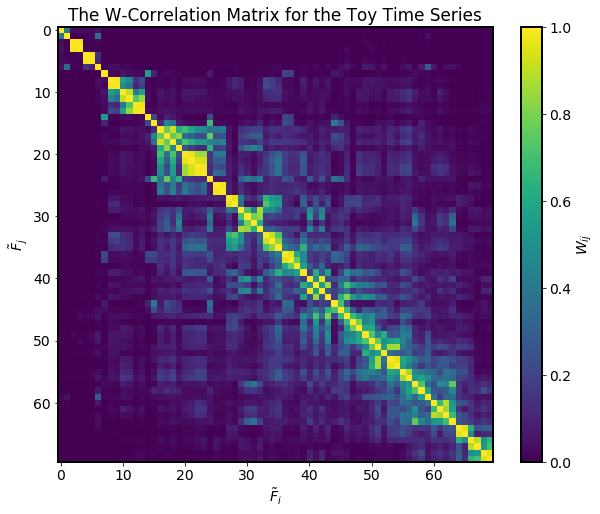

In [156]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.clim(0,1)
plt.title("The W-Correlation Matrix for the Toy Time Series");

The structure of $\mathbf{W}_{\text{corr}}$ shows a lot of correlation between the time series components, particularly in the range $7 \le i,j \le 69$. As these were the components we classified as belonging to the noise in the time series, it is no surprise that there are non-negligible correlations between all of them; this is a natural result of the noise having no underlying structural component that can be further separated.

It is important to note that $\mathbf{W}_{\text{corr}}$ is roughly split into two 'blocks': $0 \le i,j \le 6$, and $7 \le i,j \le 69$. This corresponds to two main groupings: a smoothed time series (i.e. the trend plus the two periodic components), and the residual noise. Zooming into the first seven components in $\mathbf{W}_{\text{corr}}$:

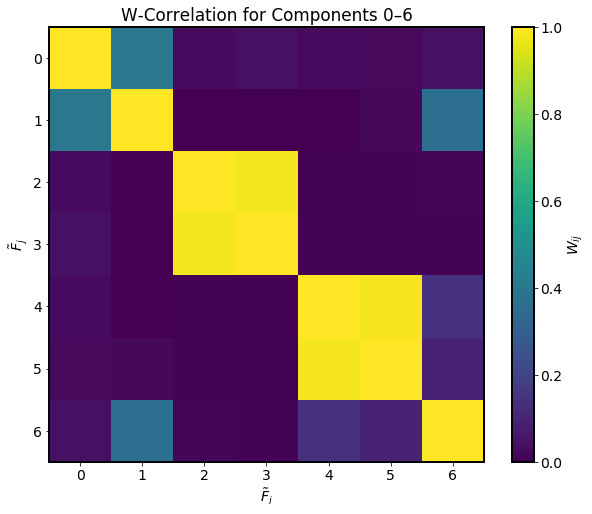

In [157]:
ax = plt.imshow(Wcorr)
plt.xlabel(r"$\tilde{F}_i$")
plt.ylabel(r"$\tilde{F}_j$")
plt.colorbar(ax.colorbar, fraction=0.045)
ax.colorbar.set_label("$W_{ij}$")
plt.xlim(-0.5,6.5)
plt.ylim(6.5,-0.5)
plt.clim(0,1)
plt.title(r"W-Correlation for Components 0–6");

The initial appearance-based groupings we made for the first six components are supported by the corresponding w-correlation values. $\tilde{F}_0$ and $\tilde{F}_1$ have $W_{0,1} = 0.40$, suggesting they should be paired. $\tilde{F}_1$ and $\tilde{F}_6$ also have $W_{1,6} = 0.39$, suggesting $\tilde{F}_6$ should also be grouped with $\tilde{F}_0$ and $\tilde{F}_1$ as a trend component. However, $\tilde{F}_6$ also has a slight w-correlation with $\tilde{F}_4$ and $\tilde{F}_5$, but since $\tilde{F}_4$ and $\tilde{F}_5$ have no w-correlation with $\tilde{F}_0$ and $\tilde{F}_1$, we choose to keep $\tilde{F}_6$ with $\tilde{F}_0$ and $\tilde{F}_1$.

Our prior groupings of  $\tilde{F}^{\text{(periodic 1)}} = \tilde{F}_2 + \tilde{F}_3$ and $\tilde{F}^{\text{(periodic 2)}} = \tilde{F}_4 + \tilde{F}_5$ are clearly justified by the w-correlation matrix, with $W_{2,3} = 0.98$ and $W_{4,5} = 0.98$.

(Something to ponder:  the elementary components $\tilde{F}_2$ and $\tilde{F}_3$ for the toy time series are almost identical, except near the boundaries, where they diverge—see the plot *The First 12 Components of the Toy Time Series* further above. However, the w-correlation for $\tilde{F}_2$ and $\tilde{F}_3$ is almost equal to 1. Why hasn't the boundary divergence significantly impacted the w-correlation here?)

# 5. A Python Class for SSA<a name="Section4"></a>

So far, the lines of code written to perform SSA on a time series have been spread through a number of cells, and are far outnumbered by the lines of code written to generate pretty plots. It is time to collect the SSA code into a handy class, imaginatively named *`SSA`*, which will form the basis for the rest of this notebook. Each instance of the class will contain the decomposition of a time series for some window length $L$, and provide useful methods to analyse, plot and reconstruct the time series.

To summarise the SSA algorithm:
1. For a time series $F = (f_0, \ f_1, \ldots, \ f_{N-1})$, and a window length $L$, form the trajectory matrix $\mathbf{X}$, with columns given by the vectors $(f_i, \ldots, f_{L+i-1})^{\text{T}}$, $0 \le i \le N-L$.
2. Decompose $\mathbf{X}$ with the singular value decomposition, $\mathbf{X} = \sum_{i=0}^{d-1}\sigma_i U_i V^{\text{T}}_i$.
3. Construct the $d$ elementary matrices $\mathbf{X}_i = \sigma_i U_i V^{\text{T}}_i$.
4. Diagonally average the $\mathbf{X}_i$ to form the elementary time series components $\tilde{F}_i$, such that $F = \sum_{i=0}^{d-1} \tilde{F}_i$.
5. Calculate and store the weighted correlation matrix, $\mathbf{W}_{\text{corr}}$, for the $\tilde{F}_i$.

The task of grouping and classifying the elementary components $\tilde{F}_i$ is left to the user.

In [158]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)
        

## 6. The Window Length<a name="Section5"></a>
We have now established the machinery to easily investigate the effect of the window length parameter, $L$, on the decomposition of our toy time series.

### 6.1 $L = 2$ <a name="Section5.1"></a>
A window length of 2 may seem like a useless choice, but it's a good place to start and watch the time series get decomposed into more and more components. We'll use the handy `SSA.components_to_df()` method to return a Pandas DataFrame and plot all elementary components at once.

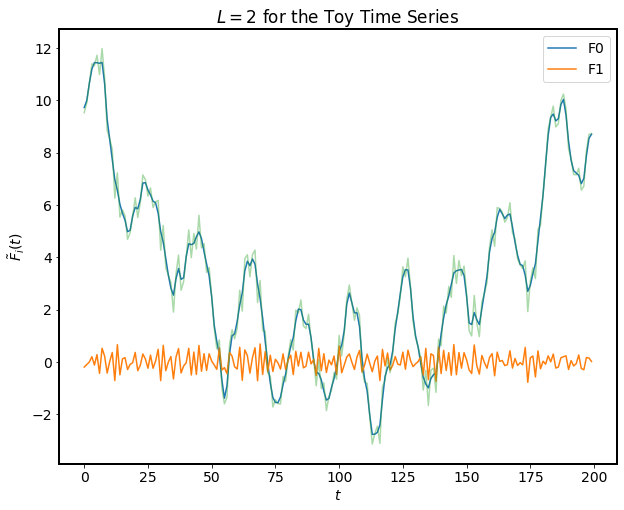

In [159]:
F_ssa_L2 = SSA(F, 2)
F_ssa_L2.components_to_df().plot()
F_ssa_L2.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=2$ for the Toy Time Series");

For $L=2$ we can only expect two elementary components to be returned. Even for such a small window length, the SSA algorithm has started to separate the high-frequency noise from the series, giving us a somewhat-denoised version of the original series in the component $\tilde{F}_0$.

### 6.2 $L = 5$<a name="Section5.2"></a>
Let's go up to a window length of 5, and see what happens to the elementary components:

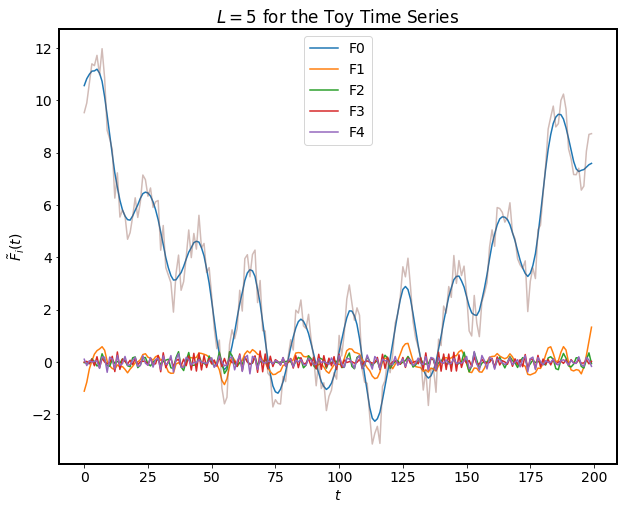

In [160]:
F_ssa_L5 = SSA(F, 5)
F_ssa_L5.components_to_df().plot()
F_ssa_L5.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title(r"$L=5$ for the Toy Time Series");
plt.show()

We see that $\tilde{F}_0$ is now a well-and-truly denoised version of the original series. $\tilde{F}_1$ is a poorly resolved periodic component, while $\tilde{F}_2$ to $\tilde{F}_4$ are just noise.

### 5.3 $L = 20$<a name="Section5.3"></a>

Let's quadruple the window length, and instead of inspecting elementary components, we'll look at the resulting w-correlation matrix and make some grouping decisions first.

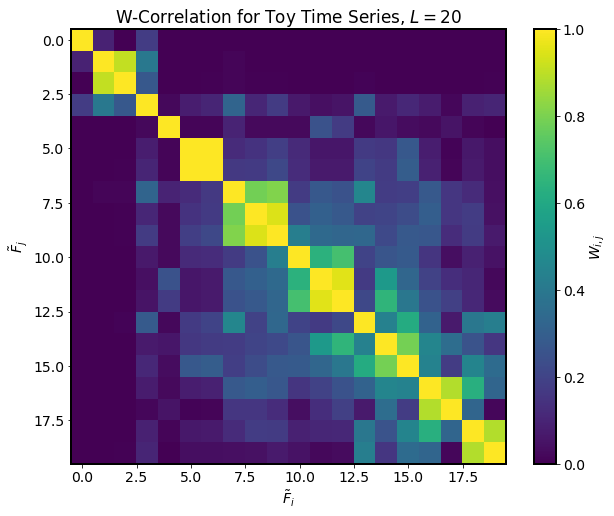

In [161]:
F_ssa_L20 = SSA(F, 20)
F_ssa_L20.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=20$");

The w-correlation matrix for $L=20$ is split (roughly) into two blocks: $\tilde{F}_0$ to $\tilde{F}_3$, and $\tilde{F}_4$ to $\tilde{F}_{19}$. Within those blocks, the size of the $W_{i,j}$ values suggest that we need to group $\tilde{F}_1$, $\tilde{F}_2$ and $\tilde{F}_3$, and group all $ \tilde{F}_4, \ldots,\tilde{F}_{19}$. This grouping is certainly not ideal, as $\tilde{F}_3$ has non-negligible w-correlation with components in the second block. We'll plot our chosen component groupings, along with $\tilde{F}_3$ on its own, and see if we're justified in our choice of grouping: 

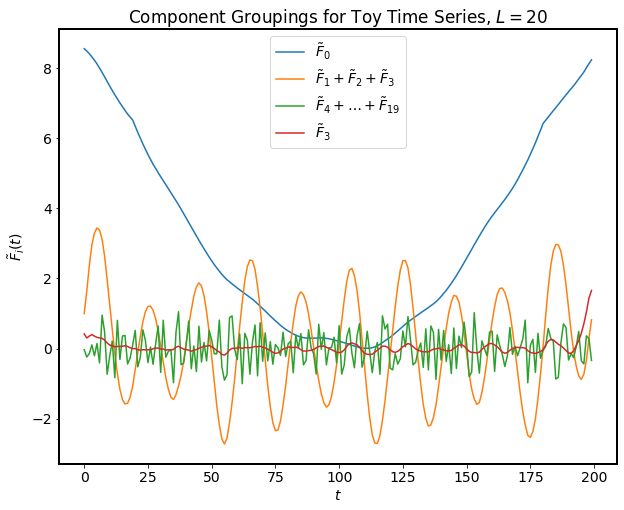

In [162]:
F_ssa_L20.reconstruct(0).plot()
F_ssa_L20.reconstruct([1,2,3]).plot()
F_ssa_L20.reconstruct(slice(4,20)).plot()
F_ssa_L20.reconstruct(3).plot()
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.title("Component Groupings for Toy Time Series, $L=20$");
plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+\tilde{F}_2+\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{19}$",
            r"$\tilde{F}_3$"]);

For $L = 20$ we begin to see the trend and periodic components start to take shape. The single component $\tilde{F}_0$ looks like the parabolic trend, and the group $\tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3$ is a very handsome periodicity, corresponding to the sum of the two periodic components in the original definition of the toy time series. The component $\tilde{F}_3$ is troublesome, looking like it contributes to both noise *and* periodicity. This suggests we need to increase the window length and see if we get an improved separation of noise and periodicity.

### 5.4 $L = 40$<a name="Section5.4"></a>

Once again, we'll double the window length and inspect the w-correlation matrix first.

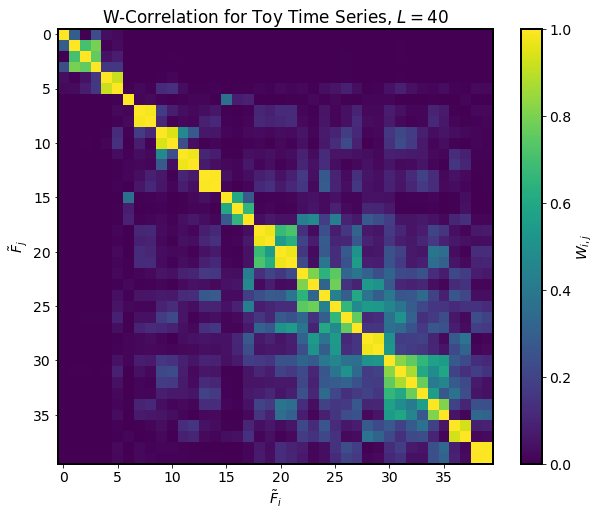

In [163]:
F_ssa_L40 = SSA(F, 40)
F_ssa_L40.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=40$");

The w-correlation matrix for $L=40$ retains the two-block structure, with $\tilde{F}_0, \ldots, \tilde{F}_5$ in the first block, and $\tilde{F}_6, \ldots, \tilde{F}_{39}$ in the second. Let us group the components as follows:
\begin{align*}
    \tilde{F}^{(0)} & = \tilde{F}_0 \\
    \tilde{F}^{(1)} & = \tilde{F}_1 + \tilde{F}_2 + \tilde{F}_3 \\
    \tilde{F}^{(2)} & = \tilde{F}_4 + \tilde{F}_5 \\
    \tilde{F}^{(3)} & = \tilde{F}_6 + \ldots + \tilde{F}_{39} \\
\end{align*}
Once again, it can be argued that this grouping is not ideal, given the non-negligible w-correlation between, for example,  $\tilde{F}_0$ and $\tilde{F}_1$. 

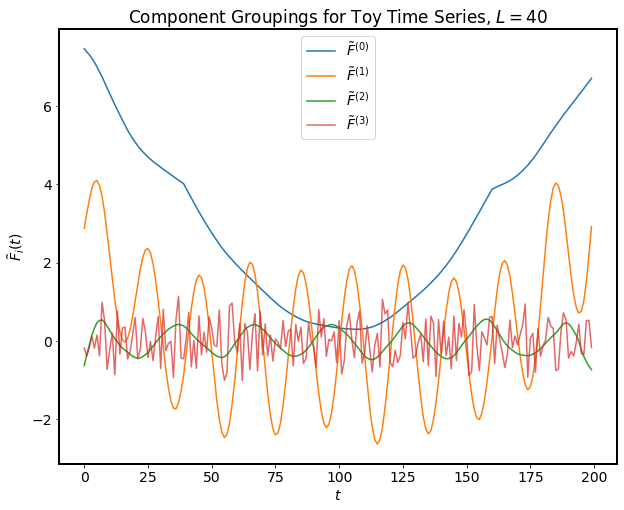

In [164]:
F_ssa_L40.reconstruct(0).plot()
F_ssa_L40.reconstruct([1,2,3]).plot()
F_ssa_L40.reconstruct([4,5]).plot()
F_ssa_L40.reconstruct(slice(6,40)).plot(alpha=0.7)
plt.title("Component Groupings for Toy Time Series, $L=40$")
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")
plt.legend([r"$\tilde{{F}}^{{({0})}}$".format(i) for i in range(4)]);

Interestingly, the trend component $\tilde{F}^{(0)}$ has started to deteriorate at $L=40$, with notable 'kinks' in the time series. The periodicity in the toy series is now separated into two periodic components of differing amplitudes and frequencies, however with significant deteriorations near the beginning and end of the time series. At this stage our window length is 20% of the length of the time series, but the poor quality of the separated components suggests that we still need to increase the window size.

### 5.5 $L = 60$<a name="Section5.5"></a>
We are now approaching our first choice of $L=70$, so it's worth investigating how the decomposition converges to our original results. Inspect the w-correlation matrix first:

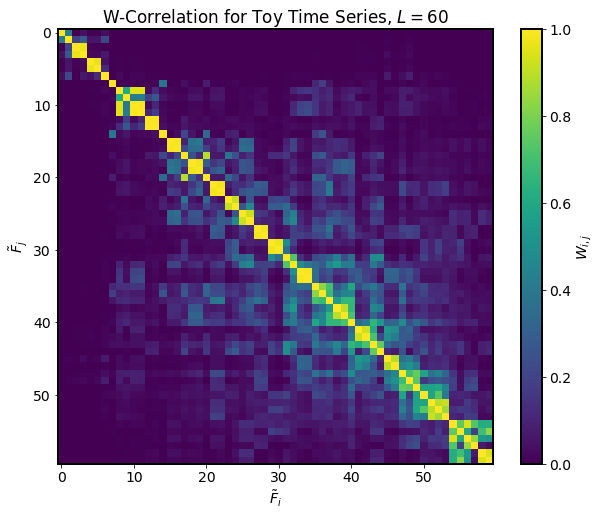

In [165]:
F_ssa_L60 = SSA(F, 60)
F_ssa_L60.plot_wcorr()
plt.title("W-Correlation for Toy Time Series, $L=60$");

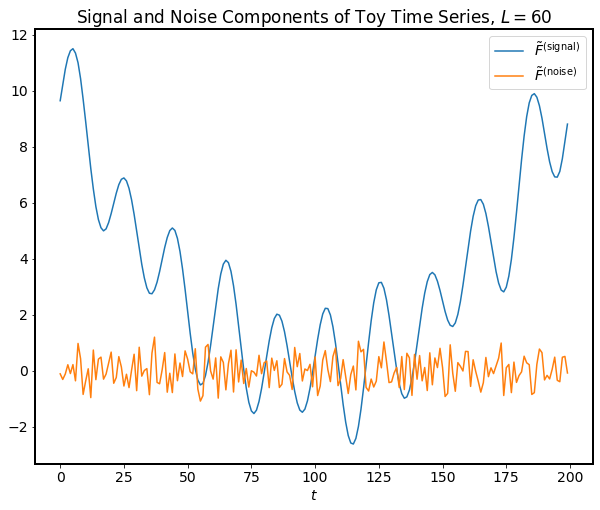

In [166]:
F_ssa_L60.reconstruct(slice(0,7)).plot()
F_ssa_L60.reconstruct(slice(7,60)).plot()
plt.legend([r"$\tilde{F}^{\mathrm{(signal)}}$", r"$\tilde{F}^{\mathrm{(noise)}}$"])
plt.title("Signal and Noise Components of Toy Time Series, $L = 60$")
plt.xlabel(r"$t$");

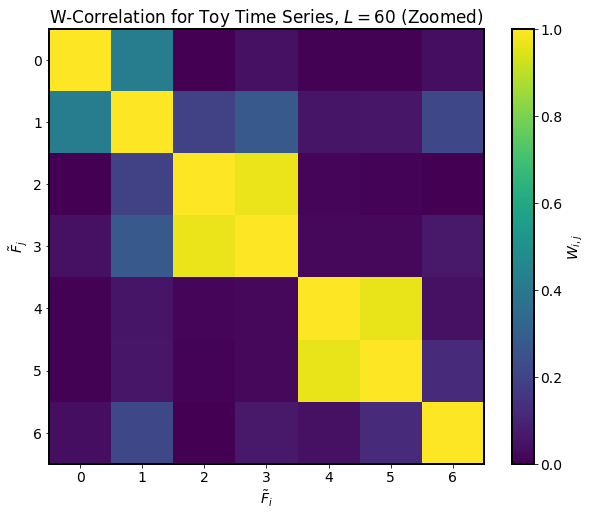

In [167]:
F_ssa_L60.plot_wcorr(max=6)
plt.title("W-Correlation for Toy Time Series, $L=60$ (Zoomed)");

# Use the reconstruction for outlier detection

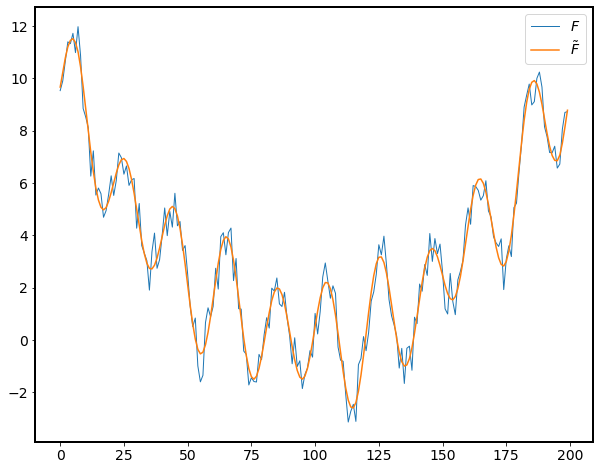

In [168]:
plt.plot(t,F, lw=1)
plt.plot(t, F_trend + F_periodic1 + F_periodic2)
legend = ["$F$"] + [r"$\tilde{F}$"]
plt.legend(legend)

## Inspecting the difference of real measurements and reconstruction

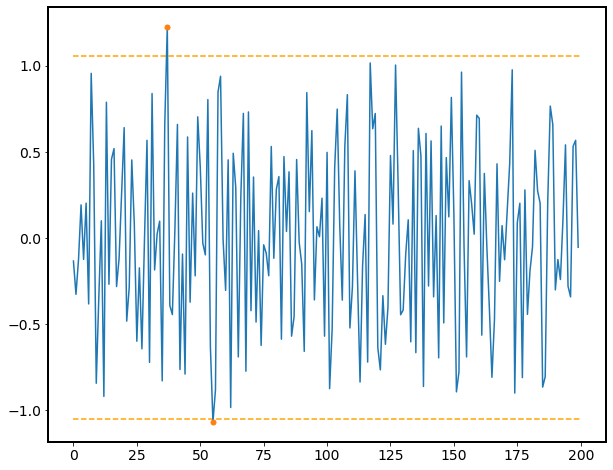

In [169]:
reconstructed = F_trend + F_periodic1 + F_periodic2
variance = F - reconstructed
mean = np.mean(variance)
std = np.std(variance)
plt.plot(t, variance)

outliers = list(np.where(abs(variance) > mean+2*std, True, False))

plt.plot(t, variance, 'o', markevery = outliers, ms=5)
plt.hlines([mean+2*std, mean-2*std], 0, len(F), color='orange', linestyles='dashed')
plt.show()

# Finally: Outliers !

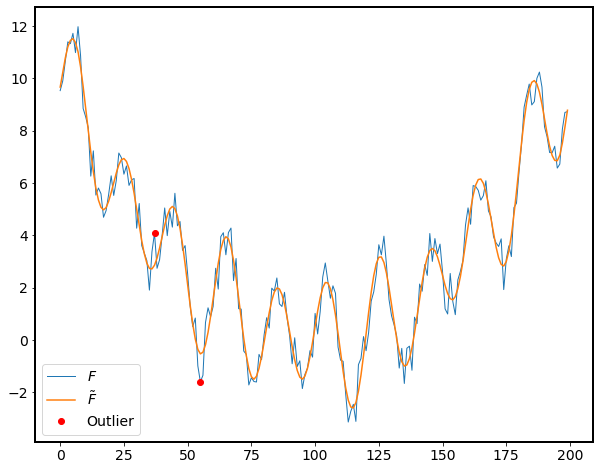

In [170]:
plt.plot(t,F, lw=1)
plt.plot(t, F_trend + F_periodic1 + F_periodic2)
plt.plot(t,F, 'o', lw=1, markevery=outliers, color='red')
legend = ["$F$", r"$\tilde{F}$", 'Outlier']
plt.legend(legend)

## Wait! Mean and Standard Deviation? Normal distribution? Where?

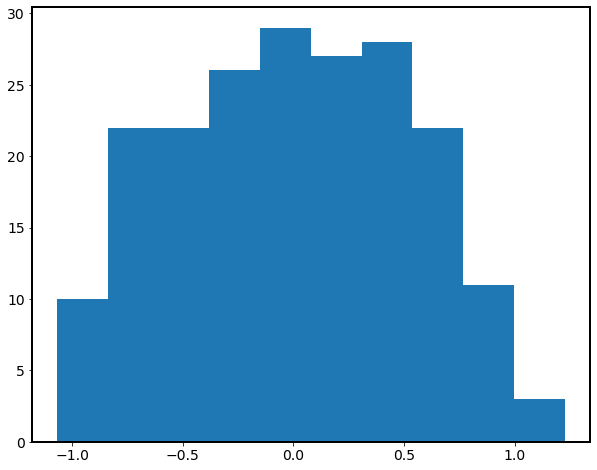

In [177]:
plt.hist(variance, bins=10)
plt.show()

## Test for normality: Shapiro Wilk

In [190]:
from scipy.stats import shapiro

stat, p = shapiro(variance)
print('Statistics=%.3f, p=%.3f' % (stat, p))

if p > 0.05:
    print('fail to reject H0 => Gaussian')
else:
    print('reject H0 => not Gaussian')

Statistics=0.977, p=0.002
reject H0 => not Gaussian


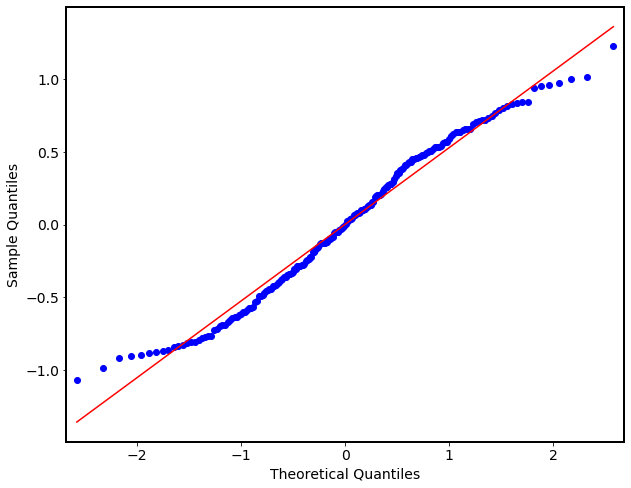

In [197]:
from statsmodels.graphics.gofplots import qqplot
qqplot(variance, line='s')
plt.show(qqplot)